In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, time, timedelta
import os
import pandas as pd
import seaborn as sns
import folium
from scipy.stats import ks_2samp
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

# Power Outages

### Getting the Data
The data is downloadable [here](https://engineering.purdue.edu/LASCI/research-data/outages/outagerisks).

A data dictionary is available at this [article](https://www.sciencedirect.com/science/article/pii/S2352340918307182) under *Table 1. Variable descriptions*.

This project uses major power outage data in the continental U.S. from January 2000 to July 2016. Here, a major power  outage is defined as a power outage that impacted at least 50,000 customers or caused an unplanned firm load loss of atleast 300MW. Interesting questions to consider include:
1. Where and when do major power outages tend to occur?
2. **What are the characteristics of major power outages with higher severity? Variables to consider include location, time, climate, land-use characteristics, electricity consumption patterns, economic characteristics, etc. What risk factors may an energy company want to look into when predicting the location and severity of its next major power outage?**
3. What characteristics are associated with each category of cause?
4. How have characteristics of major power outages changed over time? Is there a clear trend?

# Summary of Findings

### Introduction
The power outage dataset includes 1534 observations of 55 variables on power outages that have occurred in the U.S. from January 2000 to July 2016. The variables include data about an outage's general information, the affected region's climate informatoin, outage event information, regional electricity consumption, regional economic characteristics, and regional land-use characteristics. In this project, I will be investigating when and where major power outages occur and if certain climate patterns affect the likelihood of having major power outages. The  variable types I'm most interested in with my analysis will be the general information, event information, climate region information, as well as some electricity consumption information.

### Cleaning
To complete the cleaning, I will first read the csv into a pandas dataframe, filter it out to only include major outage entries, and combine the date and time columns into single datetime columns. This will allow me to conduct my analysis much easier, since I have access to so many tools and functions with pandas that otherwise are not available to me through excel. Additionally, it leaves only the data I'm interested in analyzing since I'm including only the outages that meet the criteria of major outages. Lastly, combining columns reduces redundencies in the dataset and can potentially streamline some analysis by allowing me to call a single column of datetime objects rather two columns with date and time separately.
### EDA
I will perform EDA by mapping outages across the country by state and severity in addition to looking at the different causes of outages and how often they occur, what season outages are most likely to occur in, what climate category the affected regions are, and what consumption patterns look like for affected areas. Altogether, this will provide me with a better idea of what factors lead up to a major power outage and can potentially inform us of what to focus on to prevent future outages.

### Assessment of Missingness
For this section, I chose to assess the missingness of the OUTAGE.START column, which represents the combined columns of OUTAGE.START.DATE and OUTAGE.START.TIME. We begin our evaluation by determining whether or not the variable is Not Missing at Random (NMAR), which from domain knowledge and the provided writeup for the dataset, we have no reason to believe that the missing value has anything to do with the actual date or time that the outage began. This assumption allows us to proceed with our analysis. The next test is for Missingness at Random (MAR), which means we must plot the distributions and check if they look the same whether or not we have missing values. Below, I will plot the distributions of several of the columns and their relationships with OUTAGE.START's missingness.

Using an alpha value of 0.05 and p-value of 0.139 (TVD), we fail to reject the null hypothesis that POSTAL.CODE and OUTAGE.START come from the same distribution. This means that despite the seemingly large difference in the plots, the POSTAL.CODE (state the outage occurred in) does not have an effect on the missingness of OUTAGE.START.

Using an alpha value of 0.05 and p-value of 0.989 (Kolmogorov-Smirnov ), we fail to reject the null hypothesis that SEVERITY (variable created by putting total demand lost into 4 quartiles) and OUTAGE.START come from the same distribution. This means that despite the seemingly large difference in the plots, the severity of the outage does not have an effect on the missingness of OUTAGE.START.

Using an alpha value of 0.05 and p-value of 0.034 (Kolmogorov-Smirnov), we reject the null hypothesis that POPULATION and START.ISNULL come from the same distribution. This means that the population of the affected area has an effect on the missingness of OUTAGE.START; using our above plot, we can see that areas with smaller populations are much more likely to have missing information.

Having found another column that does influence the missingness of START, but not the actual missing value, we can conclude that this variable is MAR.

### Hypothesis Test
I will conduct a hypothesis test comparing the distribution of power outages for all four seasons. 

The null hypothesis is that the distributions of power outages in the Summer is the same as that of Winter, Spring, and Fall. The alternative hypothesis is that the distribution of power outages in the Summer is unequal to that of Winter, Spring, and Fall.

The test statistic being used to measure this will be number of times a simulated outage occurs in the summer. TVD would also work, as the SEASON variable is categorical despite its numeric representation, but this is the simplest test statistic to use. If we were to use TVD, the null distribution would just be all 0.25's. The distribution under the null means that there's an equal probability for an outage to occur in any given season, meaning that the probability for an outage to occur in any of the four seasons should be 0.25.

Using a significance level of 0.05 and p-value of 0.0 across 10000 simulations, we reject the null hypothesis that the distribution of power outages is equal across all seasons. We see that the observed number of outages in the Summer greatly surpasses that of all other seasons.

# CODE

### Cleaning and EDA
- Note that the data is given as an Excel file rather than a CSV. Open the data in Excel or another spreadsheet application and determine which rows and columns of the Excel spreadsheet should be ignored when loading the data in pandas.
- Clean the data.
    - The power outage start date and time is given by `OUTAGE.START.DATE` and `OUTAGE.START.TIME`. It would be preferable if these two columns were combined into one datetime column. Combine `OUTAGE.START.DATE` and `OUTAGE.START.TIME` into a new datetime column called `OUTAGE.START`. Similarly, combine `OUTAGE.RESTORATION.DATE` and `OUTAGE.RESTORATION.TIME` into a new datetime column called `OUTAGE.RESTORATION`.
- Understand the data in ways relevant to your question using univariate and bivariate analysis of the data as well as aggregations.

*Hint 1: pandas can load multiple filetypes: `pd.read_csv`, `pd.read_excel`, `pd.read_html`, `pd.read_json`, etc.*

*Hint 2: `pd.to_datetime` and `pd.to_timedelta` will be useful here.*

*Tip: To visualize geospatial data, consider [Folium](https://python-visualization.github.io/folium/) or another geospatial plotting library.*

In [2]:
# load csv into pandas dataframe, skipping the first 4 rows, as they include information about the dataset, but do not actually include any data entries.
load = pd.read_excel('outage.xlsx',skiprows=range(4))

# drop the first column, since it's mostly for formatting
load = load.drop('Unnamed: 0',axis=1)

# drop the index column and replace it with the "OBS" column, as they both accomplish the same thing
df = load.rename(columns=load.iloc[0]).drop([0,1]).reset_index().drop('index',axis=1)
df = df.set_index('OBS')

print(df.shape[0])
df.head()

1534


,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
OBS,,,,,,,,,,,,,,,,,,,,,
1,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01 00:00:00,17:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
2,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11 00:00:00,18:38:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
3,2010,10,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26 00:00:00,20:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
4,2012,6,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19 00:00:00,04:30:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
5,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18 00:00:00,02:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743


In [3]:
# filter for only the major power outages, defined in the writeup as "a power outage that impacted at least 50,000 customers or caused an unplanned firm load loss of atleast 300MW"
major_df = df.loc[(df['CUSTOMERS.AFFECTED']>=50000) | (df['DEMAND.LOSS.MW']>300)]

In [4]:
# combine the date and time columns for OUTAGE.START by setting them to datatypes that are addable. 
# Convert datetime.time object to str then timedelta
# Add date with new timedelta object, then reformat it to pandas.datetime object
major_df['OUTAGE.START'] = pd.to_datetime(major_df['OUTAGE.START.DATE']) + pd.to_timedelta(major_df['OUTAGE.START.TIME'].astype(str))
major_df.drop(['OUTAGE.START.DATE','OUTAGE.START.TIME'],axis=1,inplace=True)

<ipython-input-4-2bf43c717aa8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  major_df['OUTAGE.START'] = pd.to_datetime(major_df['OUTAGE.START.DATE']) + pd.to_timedelta(major_df['OUTAGE.START.TIME'].astype(str))
c:\users\jwang\appdata\local\programs\python\python39\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [5]:
# Repeat the same process as above, but for OUTAGE.RESTORATION instead of OUTAGE.START
major_df['OUTAGE.RESTORATION'] = pd.to_datetime(major_df['OUTAGE.RESTORATION.DATE']) + pd.to_timedelta(major_df['OUTAGE.RESTORATION.TIME'].astype(str))
major_df.drop(['OUTAGE.RESTORATION.DATE','OUTAGE.RESTORATION.TIME'],axis=1,inplace=True)

<ipython-input-5-0c542dd14c8f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  major_df['OUTAGE.RESTORATION'] = pd.to_datetime(major_df['OUTAGE.RESTORATION.DATE']) + pd.to_timedelta(major_df['OUTAGE.RESTORATION.TIME'].astype(str))


In [6]:
print(major_df.shape[0])
major_df.head()

807


,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,...,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,OUTAGE.START,OUTAGE.RESTORATION
OBS,,,,,,,,,,,,,,,,,,,,,
1,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,severe weather,NaN,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2011-07-01 17:00:00,2011-07-03 20:00:00
3,2010,10,Minnesota,MN,MRO,East North Central,-1.5,cold,severe weather,heavy wind,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2010-10-26 20:00:00,2010-10-28 22:00:00
4,2012,6,Minnesota,MN,MRO,East North Central,-0.1,normal,severe weather,thunderstorm,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2012-06-19 04:30:00,2012-06-20 23:00:00
5,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,severe weather,NaN,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2015-07-18 02:00:00,2015-07-19 07:00:00
6,2010,11,Minnesota,MN,MRO,East North Central,-1.4,cold,severe weather,winter storm,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2010-11-13 15:00:00,2010-11-14 22:00:00


To explore which states experience the most outages, I mapped the data and found that most of these outages occur in states with large populations or states with a large proportion of their populations in urban areas. To follow this up, I also wanted to see where the worst outages, where the most sales were lost, were most likely to occur.

In [7]:
latitude = 37.0902
longitude = -95.7129
US_map = folium.Map(location=[latitude, longitude], zoom_start=5)

counts = counts = major_df['POSTAL.CODE'].value_counts().to_frame().reset_index()
#counts = (major_df['POSTAL.CODE'].value_counts() / major_df.shape[0]).reset_index()
url = (
    "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
)
state_geo = f"{url}/us-states.json"

folium.Choropleth(geo_data=state_geo,
                  name="choropleth",
                  data=counts,
                  columns=['index','POSTAL.CODE'],
                  key_on="feature.id",
                  fill_color="YlGn",
                  fill_opacity=0.7,
                  line_opacity=.1,
                  legend_name="Number of Major Power Outages").add_to(US_map)
folium.LayerControl().add_to(US_map)

# dark grey states below are states that have no recorded major power outages in the dataset
US_map

In [8]:
# create an additional column that cuts this into 4 quartiles, depending on how much unplanned firm load loss there was
major_df['SEVERITY'] = pd.qcut(major_df['DEMAND.LOSS.MW'], 4, labels=False)
major_df['SEVERITY'].value_counts()

<ipython-input-8-3de49a0ff5ad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  major_df['SEVERITY'] = pd.qcut(major_df['DEMAND.LOSS.MW'], 4, labels=False)


0.0    244
1.0     83
3.0     75
2.0     65
Name: SEVERITY, dtype: int64

In [9]:
latitude = 37.0902
longitude = -95.7129
US_map = folium.Map(location=[latitude, longitude], zoom_start=5)
url = (
    "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
)
state_geo = f"{url}/us-states.json"

counts = counts = major_df.loc[major_df['SEVERITY'] >= 3]['POSTAL.CODE'].value_counts().to_frame().reset_index()

folium.Choropleth(geo_data=state_geo,
                  name="choropleth",
                  data=counts,
                  columns=['index','POSTAL.CODE'],
                  key_on="feature.id",
                  fill_color="YlGn",
                  fill_opacity=0.7,
                  line_opacity=.1,
                  legend_name="Number of Severe Power Outages").add_to(US_map)
folium.LayerControl().add_to(US_map)

# dark grey states below are states that have no recorded major power outages in the dataset or have no extremely severe power outages 
US_map

Knowing where these outages occur the most and where the most severe outages occur, let's explore when they occur. 

In [10]:
# Using a mathematical equation, we can calculate a season given the month. 1 = Winter, 2 = Spring, 3 = Summer, 4 = Fall
major_df['SEASON'] =  major_df['OUTAGE.START'].dt.month % 12 // 3 + 1

<ipython-input-10-2ee3fe48ef60>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  major_df['SEASON'] =  major_df['OUTAGE.START'].dt.month % 12 // 3 + 1


It seems like there's a jump in major outages in Summer, which is likely due to more extreme weather conditions and larger storms.

In [11]:
major_df['SEASON'].value_counts()

3.0    298
1.0    189
4.0    160
2.0    156
Name: SEASON, dtype: int64

Now that we know when most of these outages occur, let's explore a bit about what causes them. 

In [12]:
major_df['CAUSE.CATEGORY'].value_counts()

severe weather                   683
system operability disruption     74
equipment failure                 26
fuel supply emergency             12
public appeal                      5
intentional attack                 5
islanding                          2
Name: CAUSE.CATEGORY, dtype: int64

In [13]:
major_df.loc[major_df['CAUSE.CATEGORY'] == 'severe weather']['CAUSE.CATEGORY.DETAIL'].value_counts()

thunderstorm               171
winter storm                94
hurricanes                  70
heavy wind                  60
storm                       39
wildfire                    16
snow/ice                    13
wind/rain                   12
tornadoes                    7
winter                       7
wind storm                   6
heatwave                     4
wind                         3
hailstorm                    3
earthquake                   3
lightning                    2
flooding                     1
fog                          1
thunderstorm; islanding      1
uncontrolled loss            1
snow/ice storm               1
Name: CAUSE.CATEGORY.DETAIL, dtype: int64

In [14]:
major_df['CLIMATE.CATEGORY'].value_counts()

normal    388
cold      245
warm      170
Name: CLIMATE.CATEGORY, dtype: int64

The overwhelming majority of these outages are all due to severe weather conditions, caused by storms and heavy winds. Surprisingly, when looking into the climate category of the affected regions, most of them are considered normal or temperate. When I saw that severe weather conditions caused most of these outages, I suspected most of the regions to be especially hot or cold. This may mean that some of these power plants are ill-equipped to deal with severe weather patterns, similar to what happened in Texas earlier this year.

In [15]:
major_df['YEAR'] = major_df['OUTAGE.START'].dt.year

<ipython-input-15-a3bc27d329f1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  major_df['YEAR'] = major_df['OUTAGE.START'].dt.year


In [16]:
major_df['YEAR'].value_counts(sort=False)

2014.0     34
2005.0     44
2001.0     10
2012.0     66
2007.0     41
2009.0     50
2016.0     19
2010.0     69
2013.0     53
2002.0     12
2008.0     83
2004.0     50
2003.0     40
2015.0     49
2011.0    113
2000.0     13
2006.0     57
Name: YEAR, dtype: int64

c:\users\jwang\appdata\local\programs\python\python39\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 39.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='YEAR', ylabel='CAUSE.CATEGORY'>

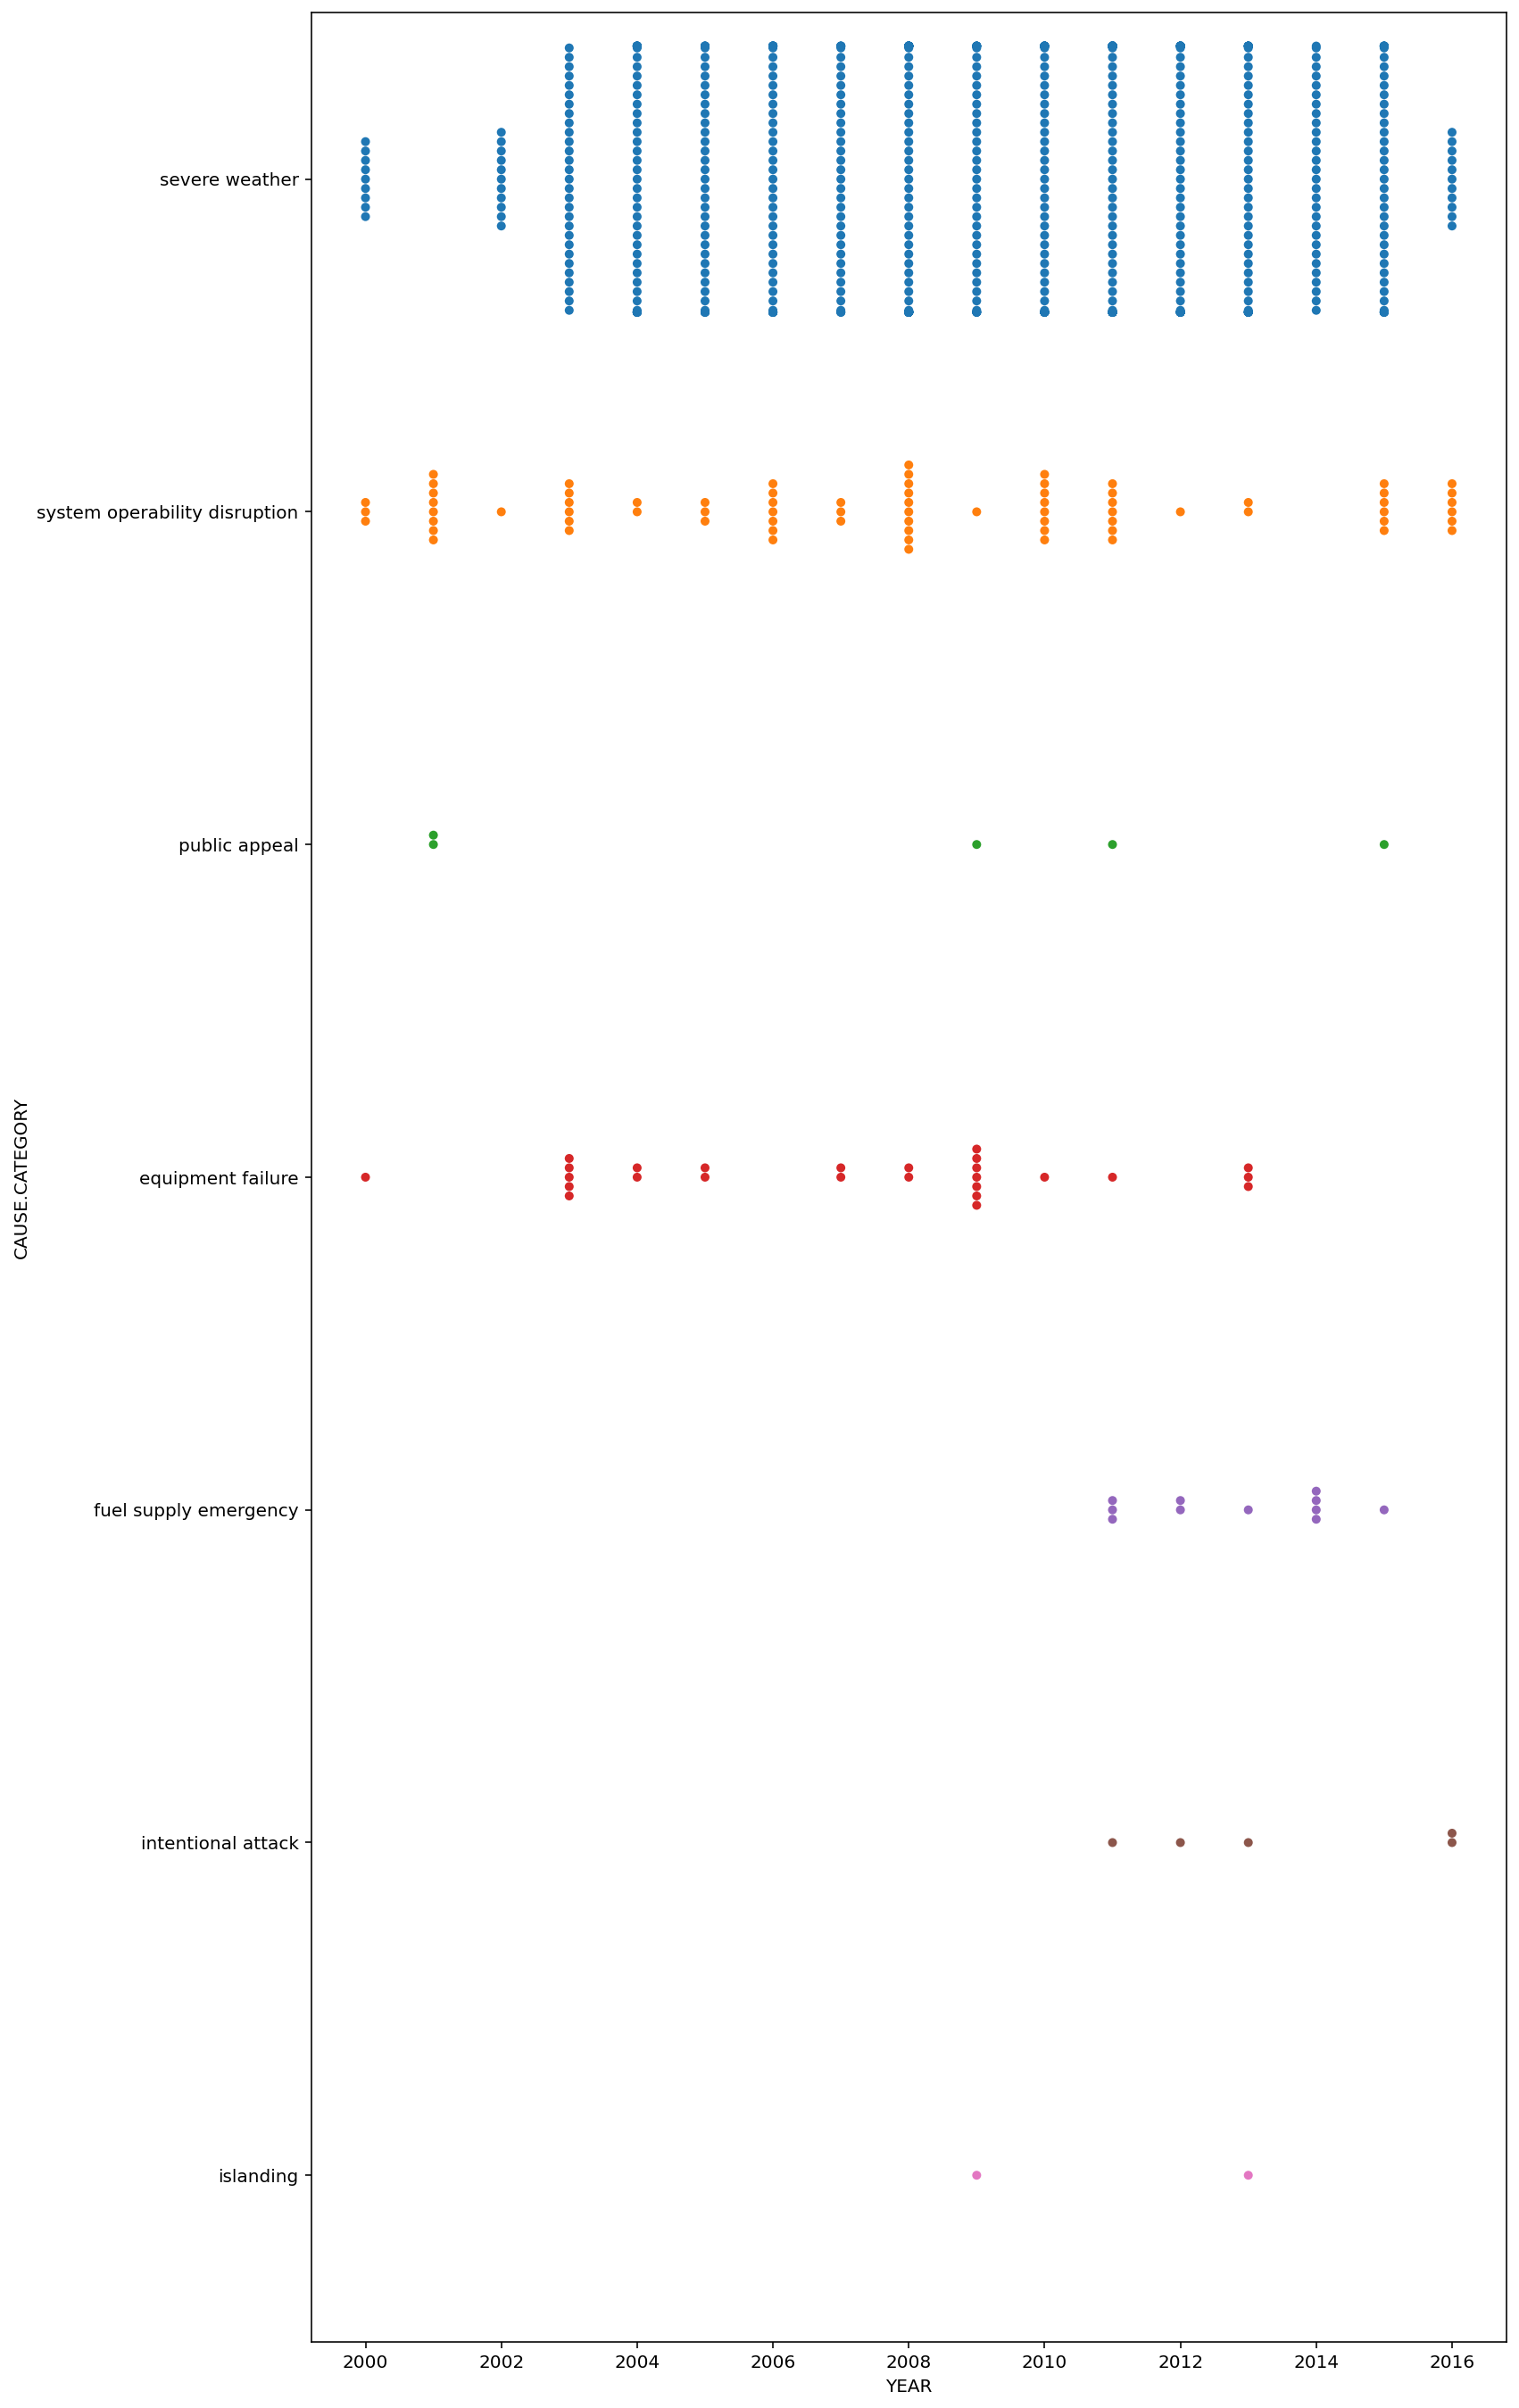

In [17]:
dim = (12, 24)
fig, ax = plt.subplots(figsize=dim)
sns.swarmplot(x="YEAR", y="CAUSE.CATEGORY", ax=ax, data=major_df)

### Assessment of Missingness
- Assess the missingness of a column that is not missing by  design.

In [18]:
# Before beginning our analysis, we need to create a T/F column that we can group on and/or shuffle
major_df['START.ISNULL'] = major_df['OUTAGE.START'].isnull()

<ipython-input-18-b6595c950d11>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  major_df['START.ISNULL'] = major_df['OUTAGE.START'].isnull()


#### Testing Postal Code

<AxesSubplot:title={'center':'Distribution of OUTAGE.START Missingness Across States'}, xlabel='POSTAL.CODE'>

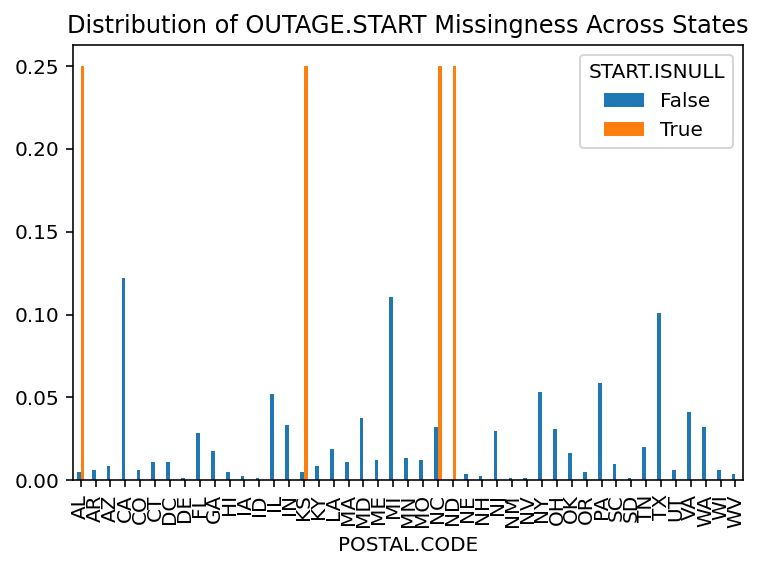

In [19]:
# Plot emperical distribution, do the different groups show drastically different distributions?
emp_distr = (
    major_df
    .pivot_table(index='POSTAL.CODE',columns='START.ISNULL',values=None,aggfunc='size')
    .fillna(0)
    .apply(lambda x : x / x.sum())
)
emp_distr.plot(kind='bar',title='Distribution of OUTAGE.START Missingness Across States')

In [20]:
#Use tvd as test statistic, since postal code is a categorical variable
# calculate observed test statistic
observed_tvd = np.sum(np.abs(emp_distr.diff(axis=1).iloc[:,-1])) / 2
observed_tvd

# compute sample test statistic from permutations of the dataset to test null hypothesis
n_repetitions = 1000
df_pc_start = major_df.copy()[['POSTAL.CODE', 'START.ISNULL']]
tvds = []
for _ in range(n_repetitions):
    
    # shuffle the colors
    shuffled_pc = (
        df_pc_start['POSTAL.CODE']
        .sample(replace=False, frac=1)
        .reset_index(drop=True)
    )
    
    # put them in a table
    shuffled = (
        df_pc_start
        .assign(**{'Shuffled Postal Code': shuffled_pc})
    )
    
    # compute the tvd
    shuffed_emp_distributions = (
        shuffled
        .pivot_table(columns='START.ISNULL', index='Shuffled Postal Code', values=None, aggfunc='size')
        .fillna(0)
        .apply(lambda x:x/x.sum())
    )
    
    tvd = np.sum(np.abs(shuffed_emp_distributions.diff(axis=1).iloc[:,-1])) / 2
    # add it to the list of results
    
    tvds.append(tvd)

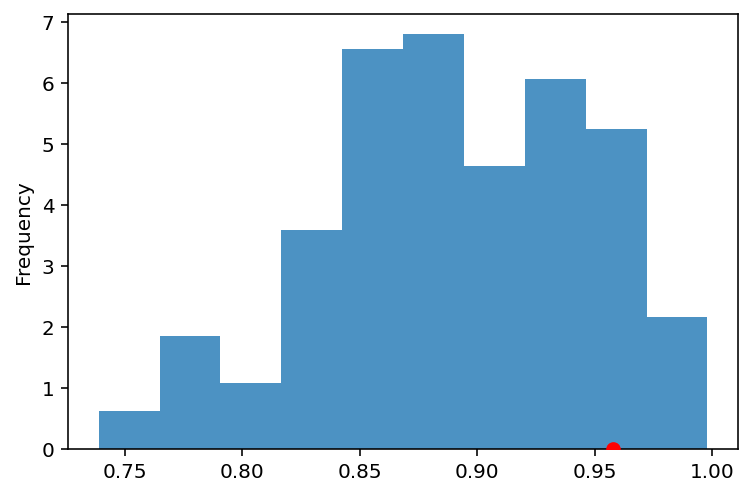

In [21]:
pd.Series(tvds).plot(kind='hist', density=True, alpha=0.8)
plt.scatter(observed_tvd, 0, color='red', s=40, zorder=10);

In [22]:
np.count_nonzero(tvds >= observed_tvd) / len(tvds)

0.135

#### Testing Severity

<AxesSubplot:title={'center':'Distribution of OUTAGE.START Missingness Across Outage Severity'}, xlabel='SEVERITY'>

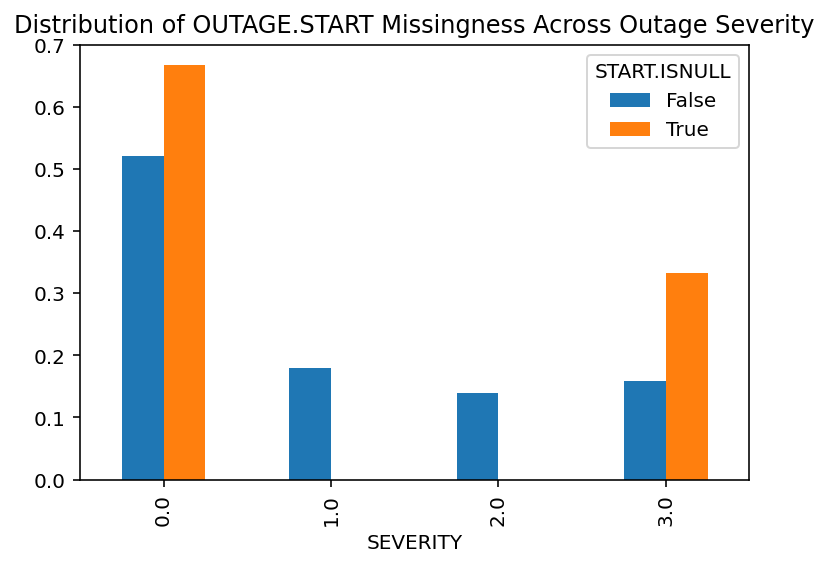

In [23]:
# Plot emperical distribution, do the different groups show drastically different distributions?
emp_distr = (
    major_df
    .pivot_table(index='SEVERITY',columns='START.ISNULL',values=None,aggfunc='size')
    .fillna(0)
    .apply(lambda x : x / x.sum())
)
emp_distr.plot(kind='bar',title='Distribution of OUTAGE.START Missingness Across Outage Severity')

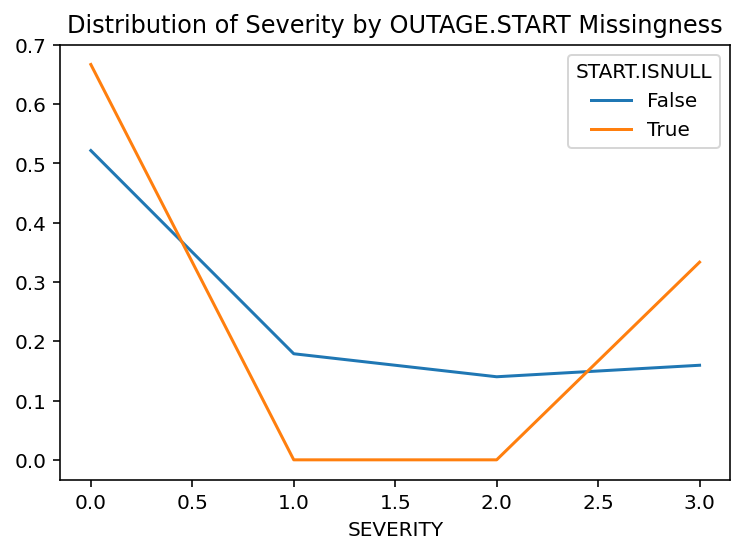

In [24]:
(
    major_df
    .pivot_table(index='SEVERITY',columns='START.ISNULL',values=None,aggfunc='size')
    .fillna(0)
    .apply(lambda x : x / x.sum())
    .plot(title="Distribution of Severity by OUTAGE.START Missingness")
);

In [25]:
# Use Kolmogorov-Smirnov test statistic, since severity is treated as a quantitative variable because there are equal intervals dividing each tier
# calculate observed test statistic and pvalue
ks_2samp(
    major_df.groupby('START.ISNULL')['SEVERITY'].get_group(True),
    major_df.groupby('START.ISNULL')['SEVERITY'].get_group(False)
)

KstestResult(statistic=0.19863013698630136, pvalue=0.9889470357509832)

#### Testing Population

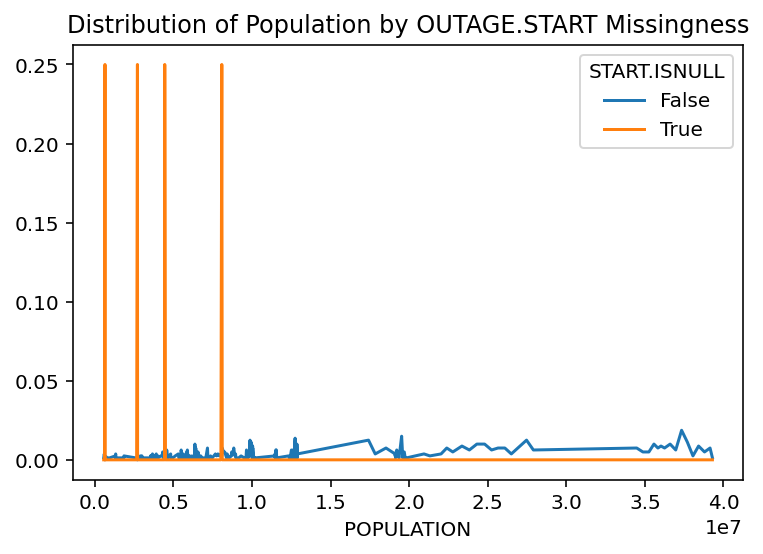

In [26]:
# Plot the distribution, do the different groups show drastically different distributions?
(
    major_df
    .pivot_table(index='POPULATION',columns='START.ISNULL',values=None,aggfunc='size')
    .fillna(0)
    .apply(lambda x : x / x.sum())
    .plot(title="Distribution of Population by OUTAGE.START Missingness")
);

In [27]:
# Use Kolmogorov-Smirnov test statistic, since severity is treated as a quantitative variable because it's a continuous variable
# calculate observed test statistic and pvalue
ks_2samp(
    major_df.groupby('START.ISNULL')['POPULATION'].get_group(True),
    major_df.groupby('START.ISNULL')['POPULATION'].get_group(False)
)

KstestResult(statistic=0.6537982565379825, pvalue=0.0343276021713711)

### Hypothesis Test
Find a hypothesis test to perform. You can use the questions at the top of the notebook for inspiration.

In [28]:
major_df.shape[0]

807

In [29]:
obs = (major_df['SEASON'] == 3).sum()
obs

298

In [30]:
N = 10000
results = []
for _ in range(N):
    simulation = np.random.choice(['winter','spring','summer','fall'], p=[0.25,0.25,0.25,0.25], size = major_df.shape[0])
    sim_summer = (simulation == 'summer').sum() #test statistic
    results.append(sim_summer)

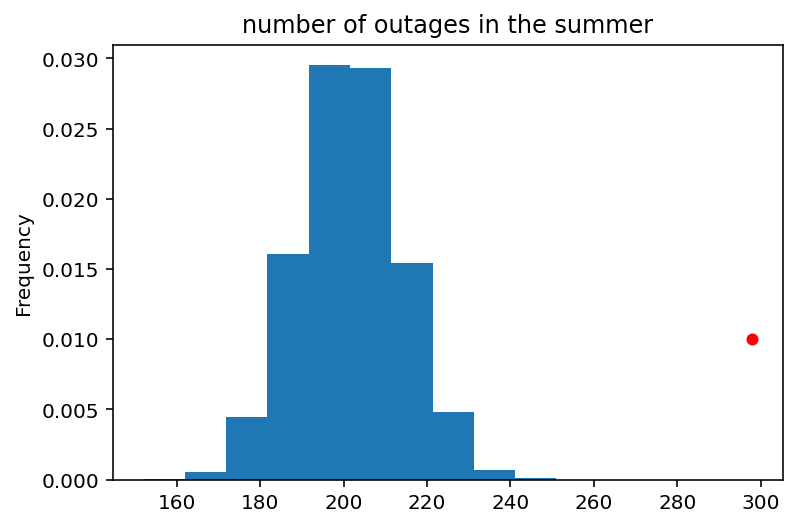

In [31]:
pd.Series(results).plot(kind='hist', density=True, title='number of outages in the summer')
plt.scatter([obs],[0.01],s=25,c='r')

In [32]:
(pd.Series(results) >= obs).mean()

0.0